In [1]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt 
import sys, gc, traceback
import fastcore.all as fc
from fastcore.test import test_close
from collections.abc import Mapping
from pathlib import Path 
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
import logging

import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor, nn, optim 
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

sys.path.append(os.path.abspath('..'))

from data_utils import *
from learners import *
from callbacks import *
from metrics import *
from utils import *

/home/korallll/Desktop/diffusion/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [112]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

logging.disable(logging.WARNING)

set_seed(42)

In [113]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [114]:
def conv(input_channels, output_channels, kernel_size=3, act=True):
    res = nn.Conv2d(in_channels=input_channels,
                    out_channels=output_channels,    
                    kernel_size=kernel_size,
                    padding=kernel_size//2
    )
    if act: res = nn.Sequential(res, nn.ReLU())
    return res 

def get_model():
    return nn.Sequential(conv(1,8), conv(8,16), conv(16,32), conv(32,64), conv(64,10, act=False), nn.Flatten()).to('cpu')

In [115]:
lrf_cbs = [DeviceCB(), ProgressCB(), LRFinderCB(lr_mult=1.1)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-2, cbs=lrf_cbs)

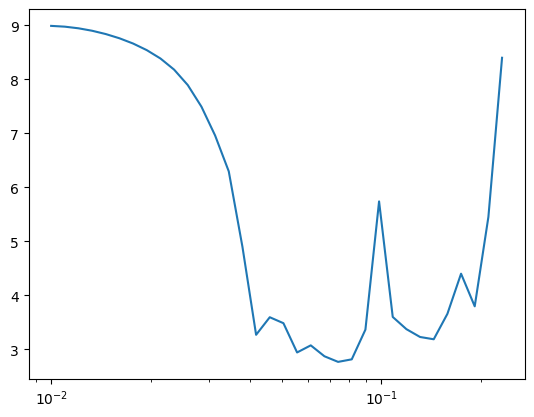

In [11]:
learn.fit(1)

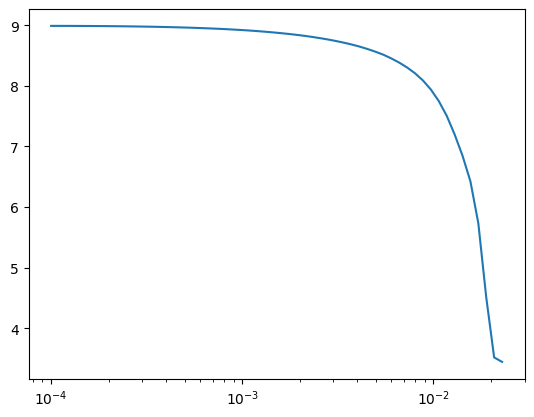

In [12]:
lrf_cbs = [DeviceCB(), ProgressCB(), LRFinderCB(lr_mult=1.1)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=lrf_cbs)
learn.fit(1)

In [116]:
# export
def clean_ipython_hist():
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n), None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc 
    hm.input_hist_raw[:] = [''] * pc 
    hm._i = hm._ii = hm._iii = hm._i00 = '' 
# clean_ipython_hist()

In [117]:
# export
def clean_tb():
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_valye'): delattr(sys, 'last_value')

In [118]:
# export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [119]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

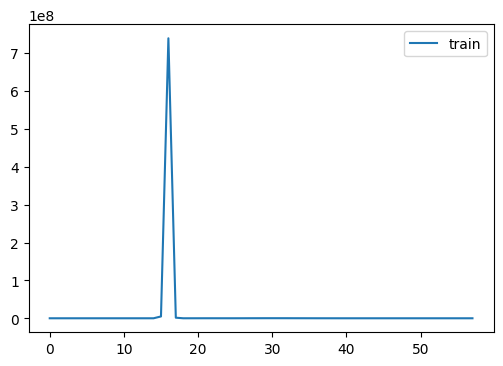

In [10]:
learn.fit(1)

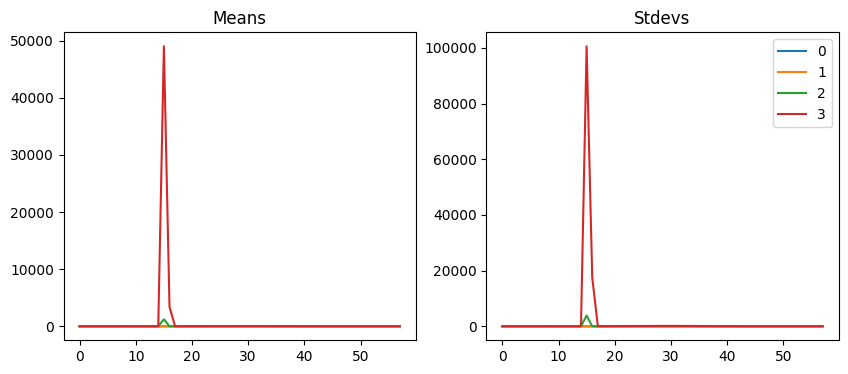

In [11]:
astats.plot_stats()

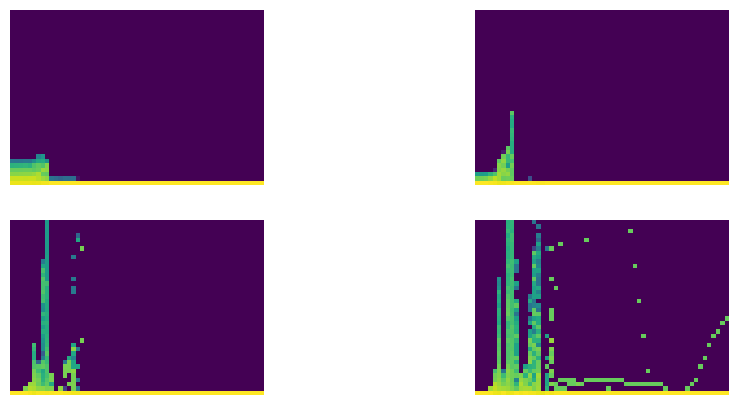

In [12]:
astats.color_dim()

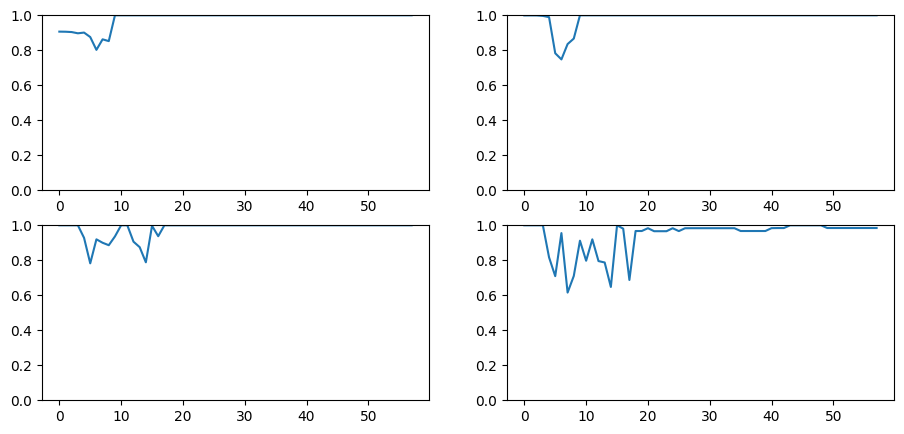

In [13]:
astats.dead_chart()

# Glorot/Xavier init

In [10]:
x = torch.randn(200,100)
for i in range(50): x = x @ torch.randn(100,100)
x[:5, :5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

In [11]:
x = torch.randn(200,100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.01)
x[:5, :5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [17]:
x = torch.randn(200,100)
for i in range(100): x = x @ (torch.randn(100,100) * 0.1)
x[:5, :5]

tensor([[ 0.02, -1.51, -2.19, -0.95, -0.36],
        [ 0.48,  0.67,  0.96,  0.35,  0.47],
        [ 0.87,  2.23,  3.14,  0.94,  1.46],
        [ 2.37,  4.70,  6.29,  1.88,  3.18],
        [-0.22,  0.38,  0.20,  0.03,  0.02]])

# BackGround

## Variance and standart deviation

In [18]:
t = torch.tensor([1.,2.,4.,18.])

In [20]:
m = t.mean(); m

tensor(6.25)

In [21]:
(t-m).mean()

tensor(0.)

In [23]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

In [24]:
(t-m).abs().mean()

tensor(5.88)

In [25]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

## Covariance

In [26]:
t

tensor([ 1.,  2.,  4., 18.])

In [27]:
u = t * 2
u *= torch.randn_like(t)/10 + 0.95

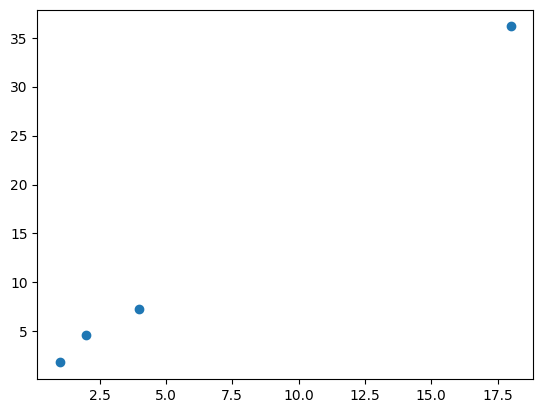

In [28]:
plt.scatter(t,u)

In [29]:
prod = (t-t.mean()) * (u - u.mean()); prod

tensor([ 55.95,  33.23,  11.69, 278.15])

In [30]:
prod.mean()

tensor(94.75)

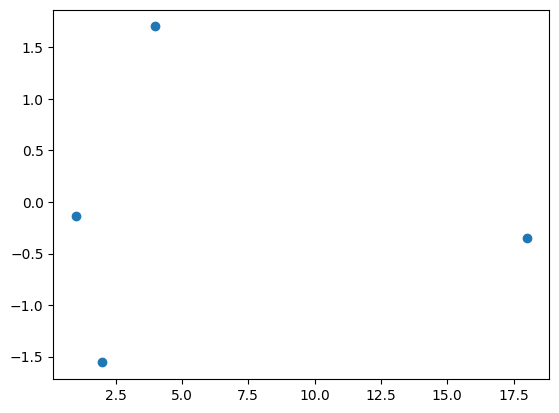

In [31]:
v = torch.randn_like(t)
plt.scatter(t,v)

In [33]:
((t-t.mean())*(v-v.mean())).mean()

tensor(-0.14)

In [32]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(-0.14)

In [34]:
cov / (t.std() * v.std())

tensor(-0.01)

## Xavier init derivation

In [36]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.03), tensor(0.94))

In [37]:
mean, sqr = 0., 0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr += y.pow(2).mean().item()
mean/100, sqr/100

(0.053731617256999015, 102.21199272155762)

In [39]:
mean, sqr = 0., 0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a * x
    mean += y.item()
    sqr += y.pow(2).item()
mean/10000, sqr/10000

(-0.024033848288375088, 1.0092486147237338)

# Kaiming/He init

In [40]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [41]:
from math import sqrt

In [46]:
w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

In [47]:
def lin(x,w,b): return x@w + b

In [63]:
ll = lin(x,w1,b1)
ll.mean(), ll.std()

(tensor(0.01), tensor(1.02))

In [68]:
def relu(x): return x.clamp_min(0.)

In [69]:
l2 = relu(ll)
l2.mean(), l2.std()

(tensor(0.42), tensor(0.60))

In [70]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * 0.1))
x[0:5, 0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In [74]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5, 0:5]

tensor([[0.18, 0.00, 1.80, 0.84, 0.50],
        [0.02, 0.00, 0.88, 0.34, 0.17],
        [0.25, 0.00, 1.83, 1.03, 0.52],
        [0.03, 0.00, 1.18, 0.67, 0.37],
        [0.03, 0.00, 0.86, 0.51, 0.34]])

## applying as init function

In [105]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


## applying an init function

In [125]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): init.kaiming_normal_(m.weight)

In [107]:
model.apply(init__weights);

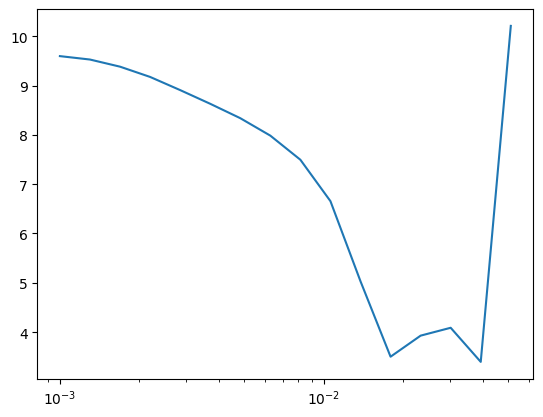

In [94]:
lrf_cbs = [DeviceCB(), ProgressCB(), LRFinderCB()]
learn = MomentumLearner(model, dls, F.cross_entropy, lr=1e-3, cbs=lrf_cbs)
learn.fit(1)

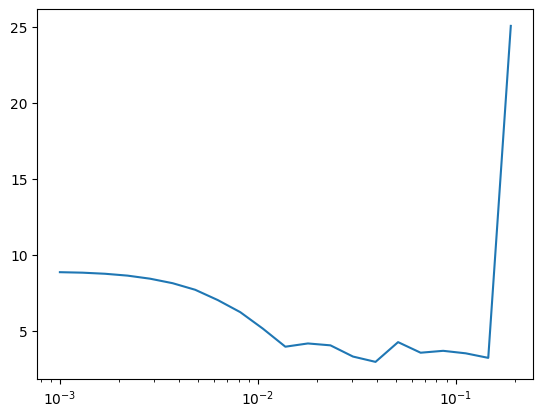

In [97]:
lrf_cbs = [DeviceCB(), ProgressCB(plot=True), LRFinderCB()]
learn = MomentumLearner(get_model().apply(init__weights), dls, F.cross_entropy, lr=1e-3, cbs=lrf_cbs)
learn.fit(1)

In [142]:

# xl,yl = 'image','label'
# name = "fashion_mnist"
# dsd = load_dataset(name)

# @inplace
# def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

# bs = 1024
# tds = dsd.with_transform(transformi)

# dls = DataLoaders.from_dd(tds, bs, num_workers=4)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to('cpu')
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d, nn.Linear)): init.kaiming_normal_(m.weight)
     

set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.1, cbs=cbs)

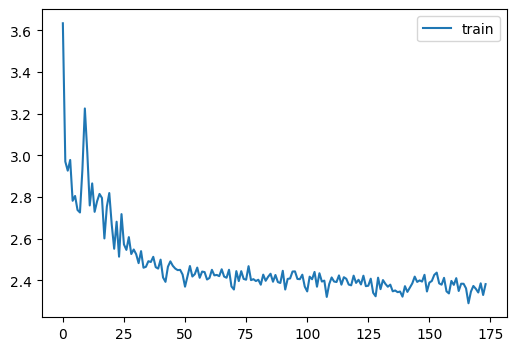

In [144]:
learn.fit(3)

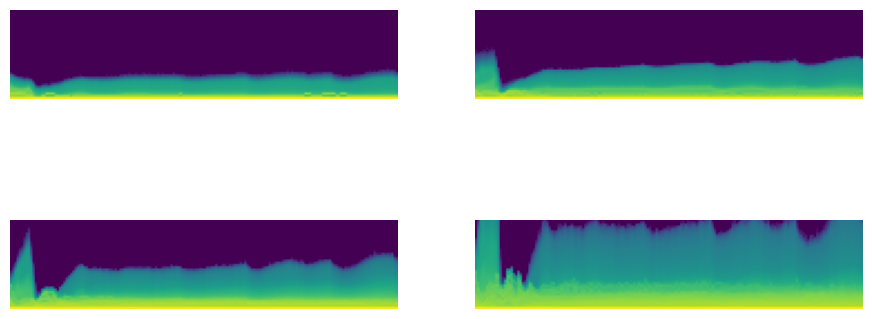

In [145]:
astats.color_dim()

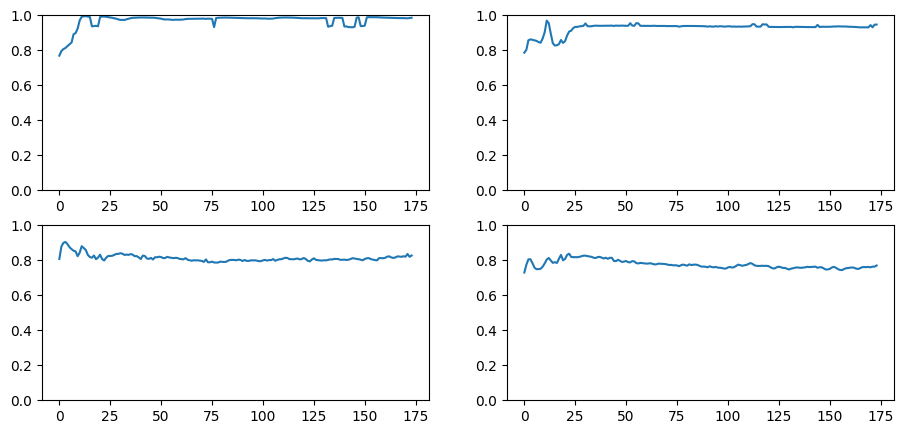

In [146]:
astats.dead_chart()

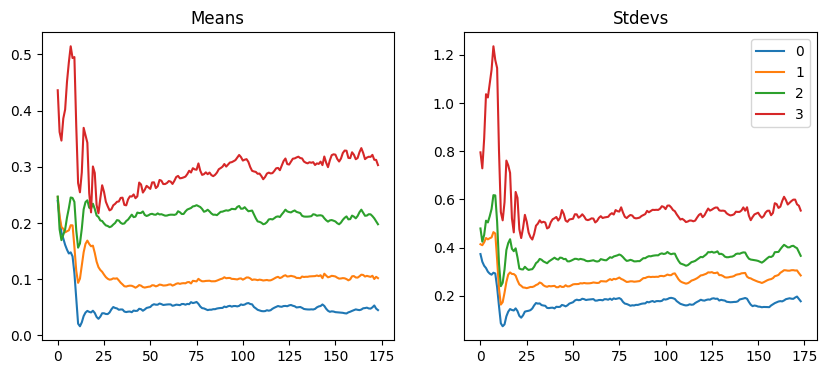

In [147]:
astats.plot_stats()